# ASL classification using ResNet50 with mean normalization and no layers freezing

In [ ]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import glob
import time
import tensorflow as tf
from pathlib import Path
import sklearn
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Preprocessing

In [ ]:
#train_dir = '/content/drive/MyDrive/ASL_project/merged_dataset/train'
train_dir = '/content/drive/MyDrive/ASL_project/training_shuffle_0_200'
test_dir = '/content/drive/MyDrive/ASL_project/test_random'

In [ ]:

train_datagen = ImageDataGenerator(rescale=1.0/255.0, featurewise_center=True, featurewise_std_normalization=False,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255.0,featurewise_center=True, featurewise_std_normalization=False)

In [ ]:
target_size=(64,64)
batch_size=64

In [ ]:
#To apply image augmentation we need a training set sample in an array
import glob
filelist = glob.glob("/content/drive/MyDrive/ASL_project/small_train_sample/**/*.png",recursive = True)
len(filelist)

192

In [ ]:
from PIL import Image
x = np.array([np.array((Image.open(fname)).resize(size=(64, 64))) for fname in filelist])


In [ ]:
train_datagen.fit(x)
test_datagen.fit(x)

In [ ]:
train_set = train_datagen.flow_from_directory(train_dir, subset='training', class_mode='categorical', batch_size=batch_size, shuffle=True, target_size=target_size)
valid_set = train_datagen.flow_from_directory(train_dir, subset='validation', class_mode='categorical', batch_size=batch_size, shuffle=True, target_size=target_size)

Found 3840 images belonging to 24 classes.
Found 960 images belonging to 24 classes.


In [ ]:
#Creating a dictionary to map index to corresponding labels
print(train_set.class_indices)
ind_to_letter = dict((v,k) for k,v in train_set.class_indices.items())
print(ind_to_letter)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


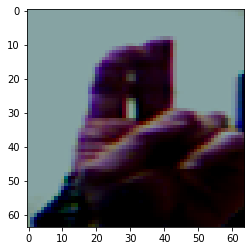

Actual letter: u


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


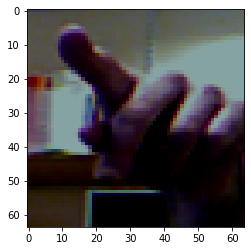

Actual letter: p


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


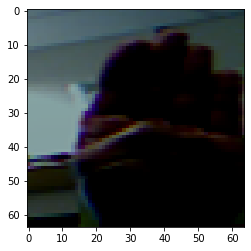

Actual letter: b


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


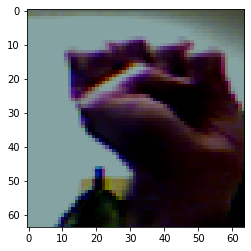

Actual letter: e


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


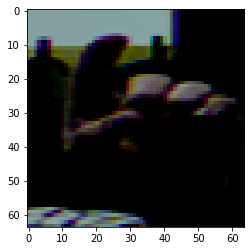

Actual letter: d


In [ ]:
#Priniting some preprocessed images
count=0
for img,label in train_set:
    count+=1
    plt.imshow(img[0])  
    plt.show()
    actual_index=np.where(label[0]==1)[0]
    print("Actual letter:",ind_to_letter[actual_index[0]])
    if(count>4):
      break

Model Download

In [ ]:
#changing the input shape
base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=(64,64,3))

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

Model Implementation

In [ ]:
#number of classes are 24
model = tf.keras.Sequential([
    base_model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(24, activation='softmax')
])
lr=0.001

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
Total params: 23,613,976
Trainable params: 23,568,536
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
patience = 1
stop_patience = 10
factor = 0.5
checkpoint_path = "/content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
]

In [ ]:
#training cycle 1
epochs = 30
history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 1.4192 - accuracy: 0.5924 
Epoch 00001: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_1/cp.ckpt
60/60 [==============================] - 2111s 35s/step - loss: 1.4192 - accuracy: 0.5924 - val_loss: 4.1556 - val_accuracy: 0.4354 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.9086
Epoch 00002: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_1/cp.ckpt
60/60 [==============================] - 368s 6s/step - loss: 0.3067 - accuracy: 0.9086 - val_loss: 1.4878 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9523
Epoch 00003: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_1/cp.ckpt
60/60 [==============================] - 368s 6s/step - loss: 0.1508 - accuracy: 0.9523 - val_loss: 0.7339 - val_accuracy: 

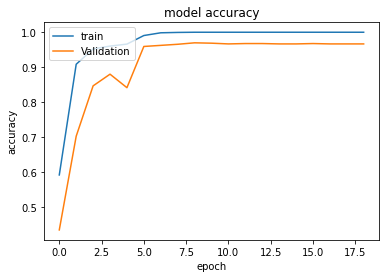

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

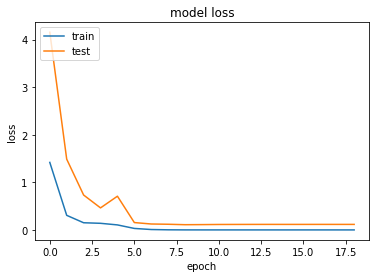

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Restoring the weights of the best model
model.load_weights('/content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_1/cp.ckpt')

In [ ]:
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_1/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
#Lodaing the model
model = tf.keras.models.load_model('/content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_1')

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
Total params: 23,613,976
Trainable params: 23,568,536
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
#testing the best model on training set
test_images = test_datagen.flow_from_directory(test_dir, class_mode='categorical', batch_size=1, target_size=target_size)

Found 240 images belonging to 24 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_images, verbose=2)

print('\nTest accuracy:', test_acc)

240/240 - 49s - loss: 0.7076 - accuracy: 0.8250 - 49s/epoch - 204ms/step

Test accuracy: 0.824999988079071


In [ ]:
#Second Round of training with new images
train_dir = '/content/drive/MyDrive/ASL_project/training_shuffle_200_400'
test_dir = '/content/drive/MyDrive/ASL_project/test_random'

In [ ]:
#The inputs pixel values are scaled between -1 and 1, sample-wise using resnet_v2.preprocess_input
#train_datagen = ImageDataGenerator(rescale=1.0/255.0, featurewise_center=True, featurewise_std_normalization=False,validation_split=0.2)
#test_datagen = ImageDataGenerator(rescale=1.0/255.0,featurewise_center=True, featurewise_std_normalization=False)
#target_size=(64,64)
#batch_size=64
train_set = train_datagen.flow_from_directory(train_dir, subset='training', class_mode='categorical', batch_size=batch_size, shuffle=True, target_size=target_size)
valid_set = train_datagen.flow_from_directory(train_dir, subset='validation', class_mode='categorical', batch_size=batch_size, shuffle=True, target_size=target_size)

Found 3840 images belonging to 24 classes.
Found 960 images belonging to 24 classes.


In [ ]:

patience = 1
stop_patience = 10
factor = 0.5
checkpoint_path = "/content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
]

In [ ]:
#training
epochs = 30
history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/30
60/60 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9737 
Epoch 00001: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_2/cp.ckpt
60/60 [==============================] - 925s 15s/step - loss: 0.0963 - accuracy: 0.9737 - val_loss: 0.0656 - val_accuracy: 0.9844 - lr: 4.8828e-07
Epoch 2/30
60/60 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9727 
Epoch 00002: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_2/cp.ckpt
60/60 [==============================] - 639s 11s/step - loss: 0.0985 - accuracy: 0.9727 - val_loss: 0.0647 - val_accuracy: 0.9844 - lr: 4.8828e-07
Epoch 3/30
60/60 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9724
Epoch 00003: saving model to /content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_2/cp.ckpt
60/60 [==============================] - 607s 10s/step - loss: 0.0975 - accuracy: 0.9724 - val_loss: 0.0640 - val_

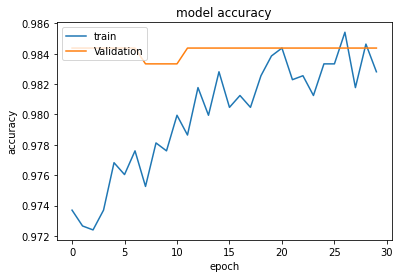

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

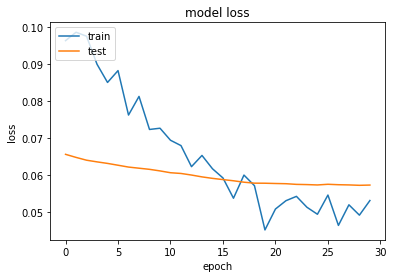

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#testing the best model on training set
test_images = test_datagen.flow_from_directory(test_dir, class_mode='categorical', batch_size=1, target_size=target_size)

Found 240 images belonging to 24 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test_images, verbose=2)

print('\nTest accuracy:', test_acc)

240/240 - 8s - loss: 0.6878 - accuracy: 0.8375 - 8s/epoch - 34ms/step

Test accuracy: 0.8374999761581421


In [ ]:
#Restoring the weights of the best model
model.load_weights('/content/drive/MyDrive/ASL_project/checkpoints/norm_trainingV3_2/cp.ckpt')
# Save the entire model as a SavedModel.
model.save('/content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_2')
#Lodaing the model
model = tf.keras.models.load_model('/content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_2')

# Check its architecture
model.summary()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL_project/saved_model/norm_trainingV3_2/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
Total params: 23,613,976
Trainable params: 23,568,536
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
test_dir = '/content/drive/MyDrive/ASL_project/test_random'
#The inputs pixel values are scaled between -1 and 1, sample-wise using resnet_v2.preprocess_input
target_size=(64,64)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,featurewise_center=True, featurewise_std_normalization=False)

#testing the best model on training set
test_images = test_datagen.flow_from_directory(test_dir, class_mode='categorical', batch_size=1, target_size=target_size)


Found 240 images belonging to 24 classes.


In [ ]:
#verifying that the loaded model is best one by again testing
test_loss, test_acc = model.evaluate(test_images, verbose=2)

print('\nTest accuracy:', test_acc)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


240/240 - 9s - loss: 0.9545 - accuracy: 0.7875 - 9s/epoch - 39ms/step

Test accuracy: 0.7875000238418579


In [ ]:
#Function for capturing live image and making prediction
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='live/photo.png', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to live/photo.png


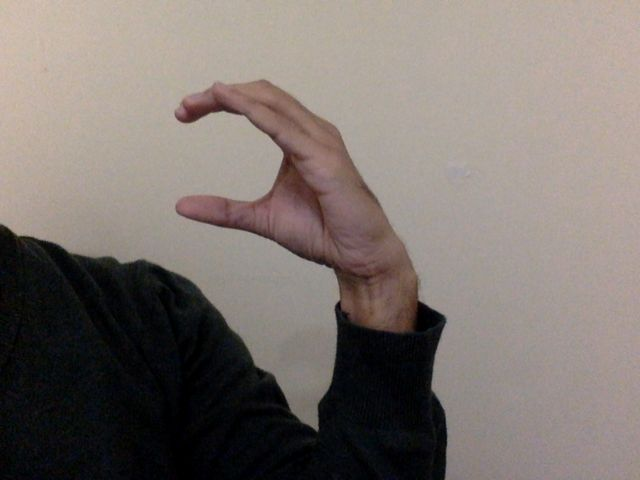

In [ ]:
#Saving the live image
from IPython.display import Image
try:
  !mkdir -p live
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
#preprocessing the live image and reshaping
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.preprocessing import image

test_image = image.load_img('live/photo.png', target_size=(64, 64))
test_image = image.img_to_array(test_image)
#test_image.reshape(1,64,64,3)
test_image=np.expand_dims(test_image,0)

In [ ]:
test_image.shape

(1, 64, 64, 3)

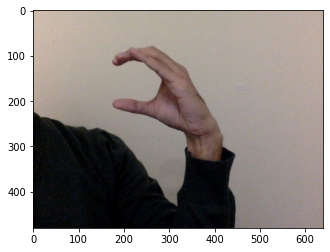

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('live/photo.png',0)
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#Applying the required remaining preprocessing operations
test_datagen = ImageDataGenerator(rescale=1.0/255.0,featurewise_center=True, featurewise_std_normalization=False)

In [ ]:
live_images = test_datagen.flow(test_image, batch_size=1)

In [ ]:
#making prediction
prediction = model.predict(live_images)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
#creating index to alphabet directory
print(test_images.class_indices)
ind_to_letter = dict((v,k) for k,v in test_images.class_indices.items())
print(ind_to_letter)
np.argmax(prediction[0])

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'k': 9, 'l': 10, 'm': 11, 'n': 12, 'o': 13, 'p': 14, 'q': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'x': 22, 'y': 23}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}


2

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


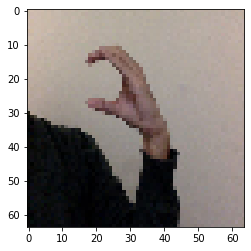

Prediction: c


In [ ]:
#Checking the prediction and printing results
for img in live_images:
    plt.imshow(img[0])
    plt.show()
    predicted_index=np.argmax(prediction[0])
    print("Prediction:",ind_to_letter[predicted_index])
    break